# RoBERTa Classifier (no pretraining)

In this notebook we will train a RoBERTa classifier from scratch for the proxy task.  This notebook is adapted from [this](https://towardsdatascience.com/fastai-with-transformers-bert-roberta-xlnet-xlm-distilbert-4f41ee18ecb2) blog post.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# from pathlib import Path 
# import os
# import torch
# import torch.optim as optim
# import random 

# # fastai
from fastai import *
from fastai.text import *
# from fastai.callbacks import *

# # transformers
#from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
from transformers import RobertaForSequenceClassification, RobertaConfig

import eval_models
from train_utils import *

In [3]:
import fastai
import transformers
import tokenizers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)
print('tokenizers version :', tokenizers.__version__)

fastai version : 1.0.59
transformers version : 2.4.1
tokenizers version : 0.4.2


In [4]:
# Parameters
seed = 42
use_fp16 = False
#bs = 16

In [5]:
model_class, config_class = RobertaForSequenceClassification, RobertaConfig

In [ ]:
# def seed_all(seed_value):
#     random.seed(seed_value) # Python
#     np.random.seed(seed_value) # cpu vars
#     torch.manual_seed(seed_value) # cpu  vars
    
#     if torch.cuda.is_available(): 
#         torch.cuda.manual_seed(seed_value)
#         torch.cuda.manual_seed_all(seed_value) # gpu vars
#         torch.backends.cudnn.deterministic = True  #needed
#         torch.backends.cudnn.benchmark = False

In [ ]:
#seed_all(seed)

### Data Pre-processing

In [ ]:
# from tokenizers.implementations import CharBPETokenizer
# from tokenizers.processors import BertProcessing

In [ ]:
# tok_path = '/home/tjtsai/.fastai/data/bscore_lm/bpe_data/tokenizer_target'
# tokenizer = CharBPETokenizer(f"{tok_path}/vocab.json", f"{tok_path}/merges.txt")
# tokenizer._tokenizer.post_processor = BertProcessing(
#     ("</s>", tokenizer.token_to_id("</s>")),
#     ("<s>", tokenizer.token_to_id("<s>")),
# )
# tokenizer.enable_truncation(max_length=256)

In [ ]:
# output = tokenizer.encode("一一丈一丂一一一 一一丁一一丁一一 一一丄一一一一一 一一丐一亀一一一 一一丈一一一一一 一一丄一一丁一一 一一丂一一一一一")

In [ ]:
#output.tokens

In [ ]:
# class TransformersBaseTokenizer(BaseTokenizer):
#     """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
#     def __init__(self, tok_dir, max_seq_len, **kwargs):
        
#         tokenizer = CharBPETokenizer(f"{tok_dir}/vocab.json", f"{tok_dir}/merges.txt")
#         tokenizer._tokenizer.post_processor = BertProcessing(
#             ("</s>", tokenizer.token_to_id("</s>")),
#             ("<s>", tokenizer.token_to_id("<s>")),
#         )
#         tokenizer.enable_truncation(max_length=max_seq_len)

#         self._pretrained_tokenizer = tokenizer
#         self.max_seq_len = max_seq_len

#     def __call__(self, *args, **kwargs): 
#         return self

#     def tokenizer(self, t:str) -> List[str]:
#         """Limits the maximum sequence length and add the special tokens"""
#         output = self._pretrained_tokenizer.encode(t)
#         return output.tokens

In [ ]:
# class CustomTokenizer():
#     '''Wrapper for TransformersBaseTokenizer tokenizer to fit into fast.ai'''
#     def __init__(self,tok_func:Callable, model_prefix:str, max_seq_len:int):
#         self.tok_func, self.model_prefix, self.max_seq_len = tok_func, model_prefix, max_seq_len
        
#     def __repr__(self) -> str:
#         res = f'Tokenizer {self.tok_func.__name__} using `{self.model_prefix}` model\n'
#         return res

#     def process_text(self, t:str, tok:BaseTokenizer) -> List[str]:
#         "Process one text `t` with tokenizer `tok`."
#         toks = tok.tokenizer(t)
#         return toks 
    
#     def _process_all_1(self,texts:Collection[str]) -> List[List[str]]:
#         'Process a list of `texts` in one process'
#         tok = self.tok_func(self.model_prefix, self.max_seq_len)
#         return [self.process_text(t, tok) for t in texts]
                                                                     
#     def process_all(self, texts:Collection[str]) -> List[List[str]]: 
#         "Process a list of `texts`."                                 
#         return self._process_all_1(texts)

In [6]:
tok_model_dir = '/home/tjtsai/.fastai/data/bscore_lm/bpe_data/tokenizer_target'
max_seq_len = 256
cust_tok = CustomTokenizer(TransformersBaseTokenizer, tok_model_dir, max_seq_len)

In [ ]:
# class TransformersVocab(Vocab):
#     def __init__(self, tokenizer: PreTrainedTokenizer):
#         super(TransformersVocab, self).__init__(itos = [])
#         self.tokenizer = tokenizer
    
#     def numericalize(self, t:Collection[str]) -> List[int]:
#         "Convert a list of tokens `t` to their ids."
#         return [self.tokenizer.token_to_id(tok) for tok in t]

#     def textify(self, nums:Collection[int], sep=' ') -> List[str]:
#         "Convert a list of `nums` to their tokens."
#         nums = np.array(nums).tolist()
#         strings = [self.tokenizer.id_to_token(num) for num in nums]
#         if sep is None:
#             sep = ''
#         return sep.join(strings)
    
#     def __getstate__(self):
#         return {'itos':self.itos, 'tokenizer':self.tokenizer}

#     def __setstate__(self, state:dict):
#         self.itos = state['itos']
#         self.tokenizer = state['tokenizer']
#         self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

In [7]:
transformer_base_tokenizer = TransformersBaseTokenizer(tok_model_dir, max_seq_len)
transformer_vocab =  TransformersVocab(tokenizer = transformer_base_tokenizer._pretrained_tokenizer)

In [8]:
pad_idx = transformer_base_tokenizer._pretrained_tokenizer.token_to_id('<pad>')

### Finetune classifier

In [9]:
bs = 64

In [10]:
bpe_path = Path('/home/tjtsai/.fastai/data/bscore_lm/bpe_data')

In [11]:
train_df = pd.read_csv(bpe_path/'train64.char.csv')
valid_df = pd.read_csv(bpe_path/'valid64.char.csv')
test_df = pd.read_csv(bpe_path/'test64.char.csv')

In [12]:
data_clas = TextDataBunch.from_df(bpe_path, train_df, valid_df, tokenizer=cust_tok, vocab=transformer_vocab,
                                  include_bos=False, include_eos=False, pad_first=False, pad_idx=pad_idx, 
                                  bs=bs, num_workers=1)

In [ ]:
# class RobertaFastaiModel(nn.Module):
#     def __init__(self, transformer_model: PreTrainedModel):
#         super(CustomTransformerModel,self).__init__()
#         self.transformer = transformer_model
        
#     def forward(self, input_ids, attention_mask=None):
        
#         # attention_mask
#         # Mask to avoid performing attention on padding token indices.
#         # Mask values selected in ``[0, 1]``:
#         # ``1`` for tokens that are NOT MASKED, ``0`` for MASKED tokens.
#         attention_mask = (input_ids!=pad_idx).type(input_ids.type()) 
#         logits = self.transformer(input_ids, attention_mask = attention_mask)[0]   
#         return logits
    
#     def reset(self): pass

In [13]:
roberta_model_path = '/home/tjtsai/.fastai/data/bscore_lm/bpe_data/models/roberta_train-target_lm'
config = config_class.from_pretrained(roberta_model_path)
config.num_labels = data_clas.c
#print(config)

In [14]:
#transformer_model = model_class.from_pretrained(roberta_model_path, config = config)
transformer_model = model_class(config) # not pretrained
custom_transformer_model = RobertaModelWrapper(transformer_model, pad_idx)

In [ ]:
learner.destroy()
torch.cuda.empty_cache()

In [15]:
learner = Learner(data_clas, custom_transformer_model, metrics=[accuracy])

In [ ]:
#print(learner.model)

In [16]:
list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.pooler]

In [17]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
#print(learner.layer_groups)

Learner split in 8 groups


In [ ]:
#learner.save('roberta_0')

In [18]:
seed_all(seed)
#learner.load('roberta_0');

In [ ]:
#learner.freeze_to(-1)

In [ ]:
#learner.summary()

In [19]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.91E-04
Min loss divided by 10: 1.00E-06


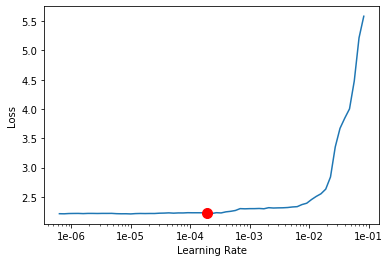

In [20]:
learner.recorder.plot(suggestion=True)

In [21]:
lr = 1e-4

In [22]:
learner.fit_one_cycle(1, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.470019,1.772660,0.354907,02:06


In [ ]:
learner.fit_one_cycle(1, lr, moms=(0.8,0.7))

In [ ]:
learner.fit_one_cycle(5, lr, moms=(0.8,0.7))

In [ ]:
learner.freeze_to(-2)
learner.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8, 0.9))

In [ ]:
learner.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8, 0.9))

In [ ]:
learner.freeze_to(-3)
learner.fit_one_cycle(2, slice(lr/2/(2.6**4),lr/2), moms=(0.8, 0.9))

In [ ]:
learner.fit_one_cycle(2, slice(lr/2/(2.6**4),lr/2), moms=(0.8, 0.9))

In [ ]:
learner.unfreeze()
learner.fit_one_cycle(1, slice(lr/10/(2.6**4),lr/10), moms=(0.8, 0.9))

In [ ]:
#learner.save('roberta_train-target_clas')
learner.load('roberta_train-target_clas')

### Evaluate Classifier

Evaluate on the proxy task -- classifying fixed-length chunks of bootleg score features.

In [23]:
data_clas_test = TextDataBunch.from_df(bpe_path, train_df, test_df, tokenizer=cust_tok, vocab=transformer_vocab,
                                  include_bos=False, include_eos=False, pad_first=False, pad_idx=pad_idx, 
                                  bs=bs, num_workers=1)

In [24]:
learner.validate(data_clas_test.valid_dl)

[1.7312081, tensor(0.3618)]

Evaluate on the original task -- classifying pages of sheet music.  We can evaluate our models in two ways:
- applying the model to a variable length sequence
- applying the model to multiple fixed-length windows and averaging the predictions

First we evaluate the model on variable length inputs.  Report results with and without applying priors.

In [25]:
train_fullpage_df = pd.read_csv(bpe_path/'train.fullpage.char.csv')
valid_fullpage_df = pd.read_csv(bpe_path/'valid.fullpage.char.csv')
test_fullpage_df = pd.read_csv(bpe_path/'test.fullpage.char.csv')

In [26]:
data_clas_test = TextDataBunch.from_df(bpe_path, train_fullpage_df, valid_fullpage_df, test_fullpage_df,
                                       tokenizer=cust_tok, vocab=transformer_vocab, include_bos=False, 
                                       include_eos=False, pad_first=False, pad_idx=pad_idx, bs=bs, num_workers=1)

In [27]:
acc, acc_with_prior = eval_models.calcAccuracy_fullpage(learner, bpe_path, train_fullpage_df, valid_fullpage_df, test_fullpage_df, databunch=data_clas_test)
acc, acc_with_prior

(0.4302147328853607, 0.4647239148616791)

Now we evaluate the model by considering multiple fixed-length windows and averaging the predictions.

In [28]:
test_ensemble_df = pd.read_csv(bpe_path/'test.ensemble64.char.csv')

In [29]:
data_clas_test = TextDataBunch.from_df(bpe_path, train_fullpage_df, valid_fullpage_df, test_ensemble_df,
                                       text_cols = 'text', label_cols = 'label', tokenizer=cust_tok, 
                                       vocab=transformer_vocab, include_bos=False, include_eos=False, 
                                       pad_first=False, pad_idx=pad_idx, bs=bs, num_workers=1)

In [30]:
acc, acc_with_prior = eval_models.calcAccuracy_fullpage(learner, bpe_path, train_fullpage_df, valid_fullpage_df, test_ensemble_df, databunch=data_clas_test, ensembled=True)
acc, acc_with_prior

(0.4348159432411194, 0.4631901979446411)

### Error Analysis

In [31]:
interp = ClassificationInterpretation.from_learner(learner)

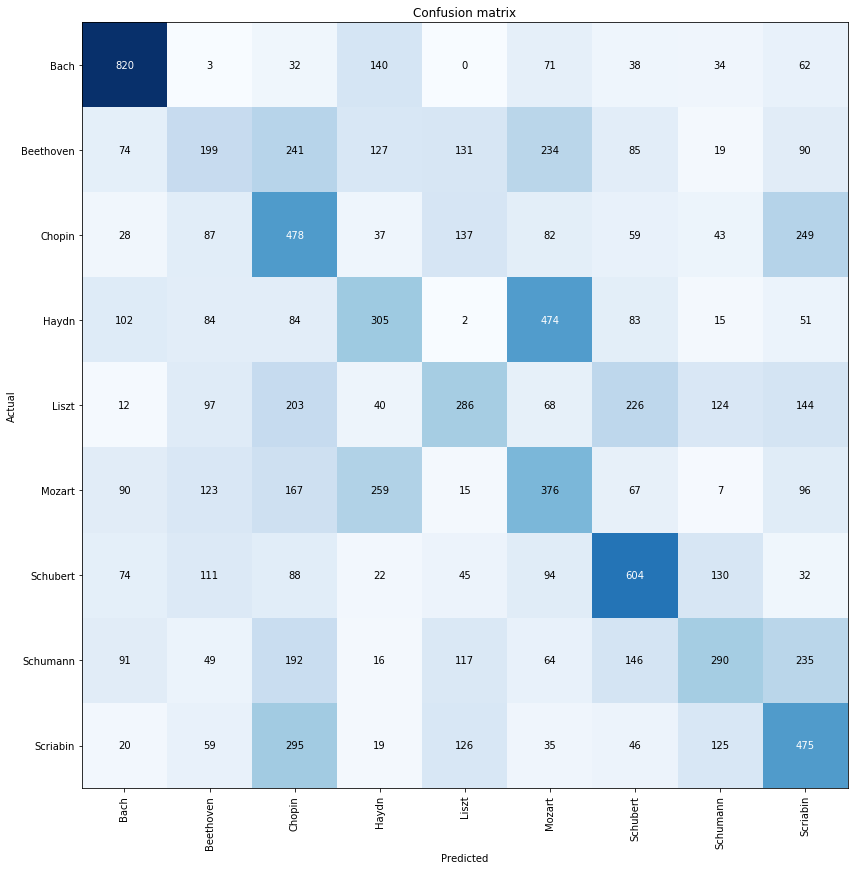

In [32]:
interp.plot_confusion_matrix(figsize=(12,12))